# Github Metrics- Activity by Repo 

This notebook will aim to query the Augur DB to access the neccessary information to be able to get the following metrics dirived from the GitHub Community Metrics working document https://docs.google.com/document/d/1Yocr6fk0J8EsVZnJwoIl3kRQaI94tI-XHe7VSMFT0yM/edit?usp=sharing

Any necessary computations from the data to get the metric value will be done as the queries are determined|

In [1]:
import psycopg2
import pandas as pd 
import sqlalchemy as salc
import json
import os
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 5)

with open("../config_temp.json") as config_file:
    config = json.load(config_file)

In [2]:
database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

## Control Cell - Set Variables and Filters 

The cell below is for generating repo_ids from the repo names. For this to work, the repo must already be in the database. If you want to manually assign a repo_id skip the cell below and read the comments on the next cell.

In [3]:
#add your repo name(s) here of the repo(s) you want to query if known (and in the database)
repo_name_set = ['augur', 'grimoirelab']
repo_set = []

for repo_name in repo_name_set:
    repo_query = salc.sql.text(f"""
                 SET SCHEMA 'augur_data';
                 SELECT 
                    b.repo_id
                FROM
                    repo_groups a,
                    repo b
                WHERE
                    a.repo_group_id = b.repo_group_id AND
                    b.repo_name = \'{repo_name}\'
        """)

    t = engine.execute(repo_query)
    repo_id =t.mappings().all()[0].get('repo_id')
    repo_set.append(repo_id)
print(repo_set)

[25440, 25448]


In [4]:
#Take this out of quotes if you want to manually assign a repo_id number(s)
#repo_set = [25440]

## Commit Analysis

### Query for commit analysis

It should be noted that each entry on this table is for files, not commits. So there can be multiple files/rows for each commits  

In [5]:
df_commits = pd.DataFrame()

for repo_id in repo_set: 

    pr_query = salc.sql.text(f"""
                SELECT
                    r.repo_name,
                    c.cmt_commit_hash AS commits,
                    c.cmt_id AS file, 
					c.cmt_added AS lines_added,
					c.cmt_removed AS lines_removed,
                    c.cmt_author_date AS date
                FROM
                	repo r,
                    commits c
                WHERE
                	r.repo_id = c.repo_id AND
                    c.repo_id = \'{repo_id}\'
        """)
    df_current_repo = pd.read_sql(pr_query, con=engine)
    df_commits = pd.concat([df_commits, df_current_repo])

df_commits = df_commits.reset_index()
df_commits.drop("index", axis=1, inplace=True)
        
df_commits

,repo_name,commits,file,lines_added,lines_removed,date
0,augur,79ee6429a570b2982fab12a20dea670a858e1141,34605744,2,2,2021-03-24
1,augur,79ee6429a570b2982fab12a20dea670a858e1141,34605745,1,1,2021-03-24
2,augur,574901f5cd8372006cc64ff2b9f14f5470bba4e4,34605767,6,6,2021-03-19
3,augur,7877b0c7937c6242e18ed712d5fb14323d13115f,34605778,2,2,2021-03-24
4,augur,7877b0c7937c6242e18ed712d5fb14323d13115f,34605779,1,1,2021-03-24
...,...,...,...,...,...,...
27673,grimoirelab,fe7ab96bdf7d0187737285af6dc3c08f5c422f14,34556304,6,2,2018-01-19
27674,grimoirelab,ff18ee3474f147c6c3b99997ac79b612fd7a2adc,34556713,2,2,2018-06-04
27675,grimoirelab,ff22f21630e80b67707db0551ca1787de843e403,34556365,1,1,2018-09-10
27676,grimoirelab,ff7bd07014362d6b1b54a7c4de6e70e8412ee1d0,34557194,15,0,2019-04-01


In [6]:
df_commits['date_time'] = pd.to_datetime(df_commits['date'], format= '%Y-%m-%d')

In [7]:
#IF YOU ONLY WANT TO LOOK AT A ONE OF THE REPOS QUERIED 
repo_focus = 'augur'
df_repo_focus = df_commits[df_commits['repo_name'] == repo_focus]
df_repo_focus = df_repo_focus.sort_values(by= "date_time")
df_repo_focus = df_repo_focus.reset_index(drop=True)

In [8]:
df_repo_focus

,repo_name,commits,file,lines_added,lines_removed,date,date_time
0,augur,c1c780958deb790fd40520873fdf8eee8e9988d9,34595109,17,1,2017-01-05,2017-01-05
1,augur,c1c780958deb790fd40520873fdf8eee8e9988d9,34595110,1,1,2017-01-05,2017-01-05
2,augur,9c742edec6169dbd8423c96c07c4725499ebaa6e,34586512,42,1,2017-01-10,2017-01-10
3,augur,4d67b9758af01f1789edab9564c5f876c3665e38,34586047,1,6,2017-01-10,2017-01-10
4,augur,9c742edec6169dbd8423c96c07c4725499ebaa6e,34586503,4,1,2017-01-10,2017-01-10
...,...,...,...,...,...,...,...
25842,augur,cb0bce873c5ff578a8b3c818f36ce7efe94a5e0e,34684610,5,0,2021-07-25,2021-07-25
25843,augur,70f60c931f3dd764579c83032dad10f24456690f,34684604,1,1,2021-07-26,2021-07-26
25844,augur,fa7e9767664c46865ec09b7479b89431fa0fe207,34684818,0,0,2021-08-01,2021-08-01
25845,augur,3a253df3838f2103ce6ed0de0a87e1bea4904820,34684343,0,0,2021-08-01,2021-08-01


### Number of commits 

In [9]:
# We will fetch all the unique commit IDs and drop the redundant ones
df_commits_unique = df_repo_focus.drop(columns = ['file'])
agg_fun = {'repo_name': 'first',  'commits': 'first', 'lines_added': 'sum', 'lines_removed': 'sum', 
                         'date': 'first', 'date_time': 'first'}
df_commits_unique = df_commits_unique.groupby(df_commits_unique['commits']).aggregate(agg_fun)
df_commits_unique = df_commits_unique.reset_index(drop=True)

#### By Day 

In [10]:
repo_daily_commits = df_commits_unique['date_time'].groupby(df_commits_unique.date_time.dt.to_period("D")).agg('count')

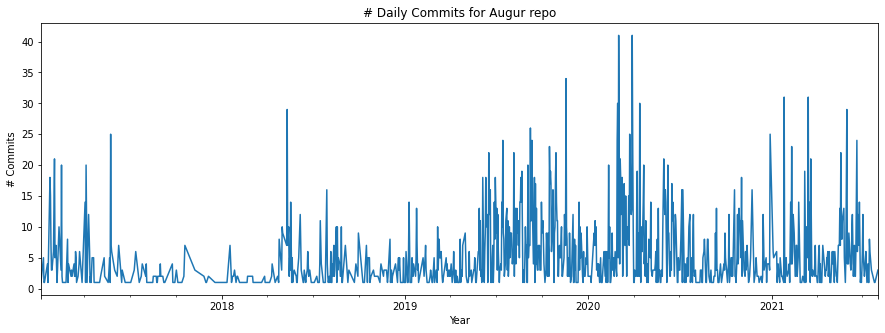

In [11]:
repo_daily_commits.plot()

plt.xlabel("Year")
plt.ylabel("# Commits")
plt.title("# Daily Commits for "+repo_focus.capitalize() +" repo")
plt.show()

#### By Week

In [12]:
repo_week_commits = df_commits_unique['date_time'].groupby(df_commits_unique.date_time.dt.to_period("W")).agg('count')

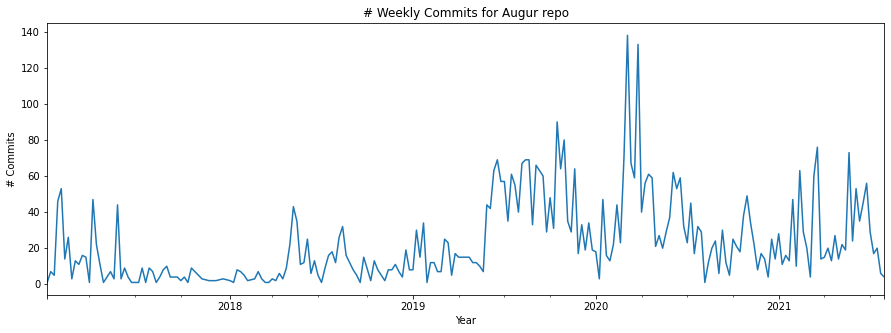

In [13]:
repo_week_commits.plot()

plt.xlabel("Year")
plt.ylabel("# Commits")
plt.title("# Weekly Commits for " + repo_focus.capitalize() + " repo")
plt.show()

#### By Month

In [14]:
repo_monthy_commits = df_commits_unique['date_time'].groupby(df_commits_unique.date_time.dt.to_period("M")).agg('count')

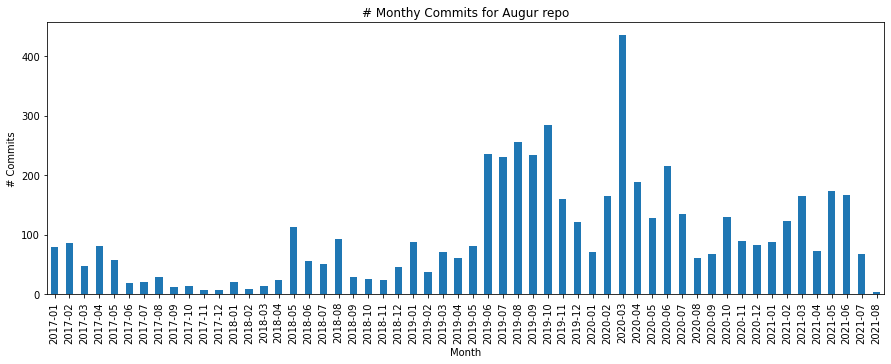

In [15]:
repo_monthy_commits.plot.bar()

plt.xlabel("Month")
plt.ylabel("# Commits")
plt.title("# Monthy Commits for " + repo_focus.capitalize() + " repo")
plt.show()

### Number of lines per commit

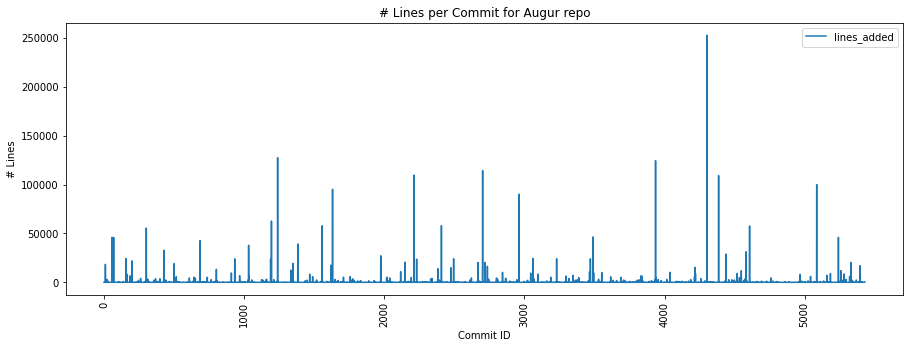

In [16]:
df_lines_repo = df_commits_unique[["commits", "lines_added"]]
df_lines_repo.plot()

plt.xlabel("Commit ID")
plt.ylabel("# Lines")
plt.title("# Lines per Commit for "+ repo_focus.capitalize() + " repo")
plt.xticks(rotation=90)
plt.show()

In [17]:
df_commits_unique.describe()

,lines_added,lines_removed
count,5431.000000,5431.000000
mean,581.224636,590.132020
std,6150.904575,7409.079865
min,0.000000,0.000000
25%,0.000000,0.000000
50%,3.000000,1.000000
75%,33.000000,14.000000
max,252656.000000,321009.000000


### Number of files per commit

In [18]:
df_files_repo = df_repo_focus.assign(file = 1)
agg_fun = {'repo_name': 'first', 'commits': 'first', 'file': 'sum', 'lines_added': 'sum', 'lines_removed': 'sum', 
                          'date': 'first', 'date_time': 'first'}
df_files_repo = df_files_repo.groupby(df_files_repo['commits']).aggregate(agg_fun)
df_files_repo = df_files_repo.sort_values(by= "date_time")
df_files_repo = df_files_repo.reset_index(drop=True)

In [19]:
df_files_repo.head()

,repo_name,commits,file,lines_added,lines_removed,date,date_time
0,augur,c1c780958deb790fd40520873fdf8eee8e9988d9,2,18,2,2017-01-05,2017-01-05
1,augur,4d67b9758af01f1789edab9564c5f876c3665e38,6,6,483,2017-01-10,2017-01-10
2,augur,e5c66bba94c38d9b30796f1885ff2d42c9fd78c3,1,0,1,2017-01-10,2017-01-10
3,augur,9c742edec6169dbd8423c96c07c4725499ebaa6e,14,580,14,2017-01-10,2017-01-10
4,augur,dfdfe76a27c449105e23153fb2692564f144b0b8,1,1,2,2017-01-10,2017-01-10


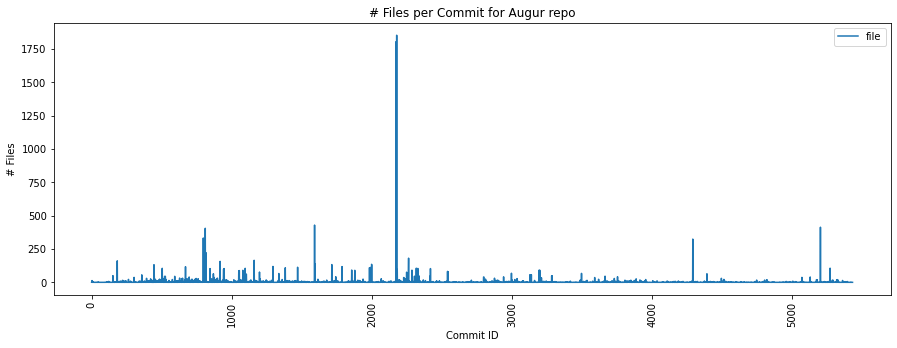

In [20]:
df_files_repo[["commits", "file"]].plot()

plt.xlabel("Commit ID")
plt.ylabel("# Files")
plt.title("# Files per Commit for "+ repo_focus.capitalize() + " repo")
plt.xticks(rotation=90)
plt.show()

In [21]:
df_files_repo.describe()

,file,lines_added,lines_removed
count,5431.00000,5431.000000,5431.000000
mean,4.75916,581.224636,590.132020
std,38.79662,6150.904575,7409.079865
min,1.00000,0.000000,0.000000
25%,1.00000,0.000000,0.000000
50%,1.00000,3.000000,1.000000
75%,2.00000,33.000000,14.000000
max,1853.00000,252656.000000,321009.000000


### Number of lines per file

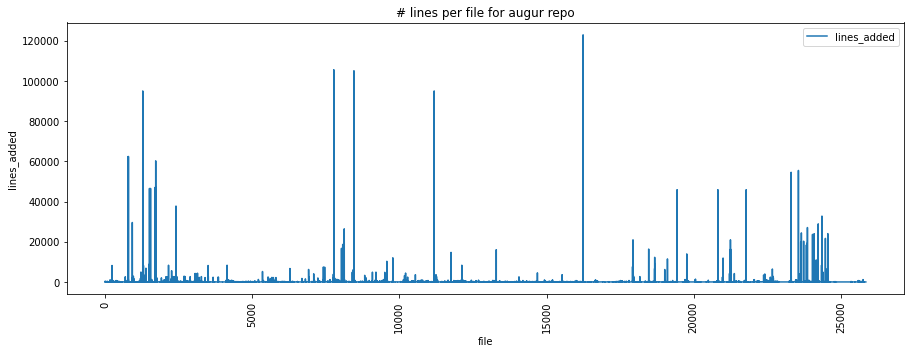

In [22]:
df_repo_focus[[ "lines_added"]].plot()

plt.xlabel("file")
plt.ylabel("lines_added")
plt.title("# lines per file for "+ repo_focus.capitalize() + " repo")
plt.xticks(rotation=90)
plt.show()

## Issue Analysis 

### Query

In [23]:
df_issues = pd.DataFrame()

for repo_id in repo_set: 

    pr_query = salc.sql.text(f"""
                SELECT
                    r.repo_name,
					i.issue_id AS issue, 
					i.gh_issue_number AS issue_number,
					i.gh_issue_id AS gh_issue,
					i.created_at AS created, 
					i.closed_at AS closed
                FROM
                	repo r,
                    issues i
                WHERE
                	r.repo_id = i.repo_id AND
                    i.repo_id = \'{repo_id}\'
        """)
    df_current_repo = pd.read_sql(pr_query, con=engine)
    df_issues = pd.concat([df_issues, df_current_repo])

df_issues = df_issues.reset_index()
df_issues.drop("index", axis=1, inplace=True)
        
df_issues

,repo_name,issue,issue_number,gh_issue,created,closed
0,augur,340115,28,213149529,2017-03-09 20:06:18,2017-04-07 21:18:01
1,augur,343231,886,682259157,2020-08-20 00:09:30,2020-08-20 00:16:50
2,augur,343216,880,679627659,2020-08-15 19:11:45,2020-08-17 14:30:04
3,augur,343467,967,724668885,2020-10-19 14:21:08,2020-10-19 14:21:34
4,augur,342738,740,628534692,2020-06-01 15:34:33,2020-08-20 10:48:14
...,...,...,...,...,...,...
1855,grimoirelab,735294,437,941801983,2021-07-12 08:23:29,2021-07-28 08:58:49
1856,grimoirelab,735295,436,924259145,2021-06-17 19:24:54,NaT
1857,grimoirelab,340606,284,559853733,2020-02-04 17:00:31,NaT
1858,grimoirelab,734649,429,889819068,2021-05-12 08:28:28,NaT


In [24]:
#IF YOU ONLY WANT TO LOOK AT A ONE OF THE REPOS QUERIED 
df_issues_focus = df_issues[df_issues['repo_name'] == repo_focus]
df_issues_focus = df_issues_focus.sort_values(by= "created")
df_issues_focus = df_issues_focus.reset_index(drop=True)

### Numer of issues Created 

#### By Day

In [25]:
df_issues_daily = df_issues_focus['created'].groupby(df_issues_focus.created.dt.to_period("D")).agg('count')

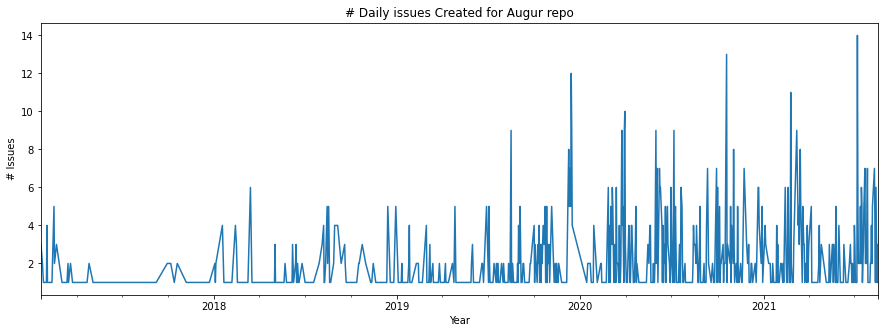

In [26]:
df_issues_daily.plot()

plt.xlabel("Year")
plt.ylabel("# Issues")
plt.title("# Daily issues Created for "+repo_focus.capitalize() +" repo")
plt.show()

#### By Week

In [27]:
df_issues_weekly = df_issues_focus['created'].groupby(df_issues_focus.created.dt.to_period("W")).agg('count')

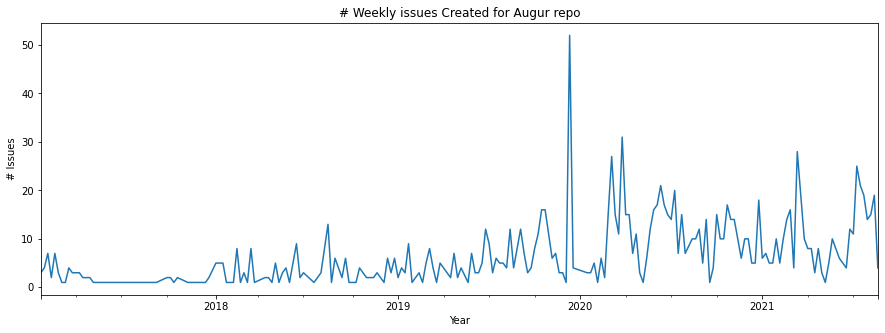

In [28]:
df_issues_weekly.plot()

plt.xlabel("Year")
plt.ylabel("# Issues")
plt.title("# Weekly issues Created for "+repo_focus.capitalize() +" repo")
plt.show()

#### By Month

In [29]:
df_issues_monthly = df_issues_focus['created'].groupby(df_issues_focus.created.dt.to_period("M")).agg('count')

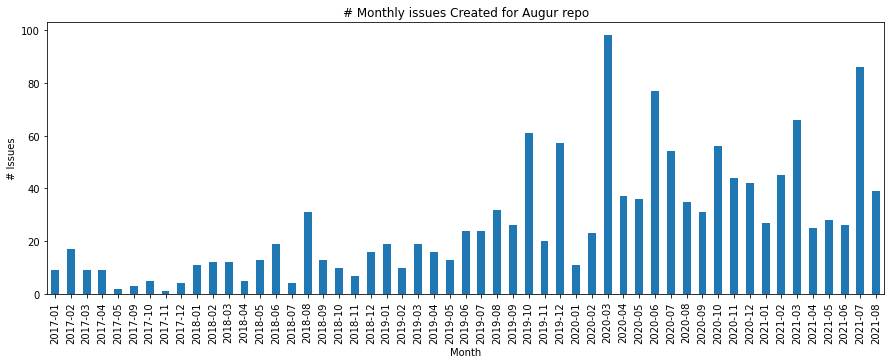

In [30]:
df_issues_monthly.plot.bar()

plt.xlabel("Month")
plt.ylabel("# Issues")
plt.title("# Monthly issues Created for "+repo_focus.capitalize() +" repo")
plt.show()

### Numer of issues closed

#### By Day

In [31]:
df_issues_closed_daily = df_issues_focus['closed'].groupby(df_issues_focus.closed.dt.to_period("D")).agg('count')

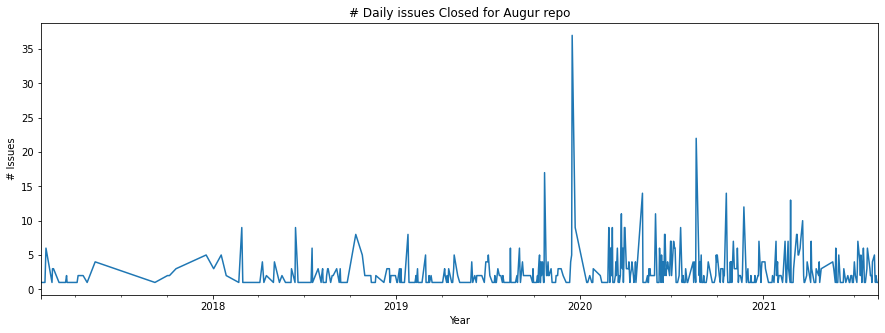

In [32]:
df_issues_closed_daily.plot()

plt.xlabel("Year")
plt.ylabel("# Issues")
plt.title("# Daily issues Closed for "+repo_focus.capitalize() +" repo")
plt.show()

#### By Week

In [33]:
df_issues_closed_weekly = df_issues_focus['closed'].groupby(df_issues_focus.closed.dt.to_period("W")).agg('count')

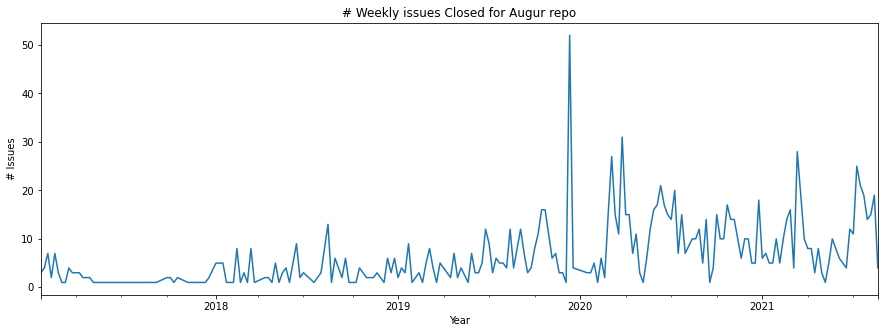

In [34]:
df_issues_weekly.plot()

plt.xlabel("Year")
plt.ylabel("# Issues")
plt.title("# Weekly issues Closed for "+ repo_focus.capitalize() +" repo")
plt.show()

#### By Month

In [35]:
df_issues_closed_monthly = df_issues_focus['closed'].groupby(df_issues_focus.closed.dt.to_period("M")).agg('count')

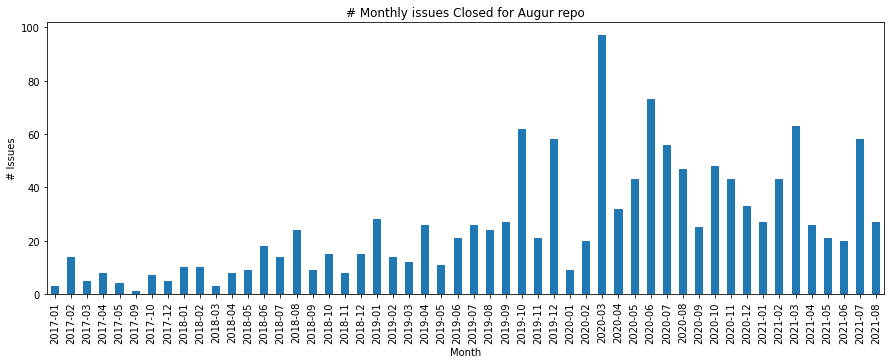

In [36]:
df_issues_closed_monthly.plot.bar()

plt.xlabel("Month")
plt.ylabel("# Issues")
plt.title("# Monthly issues Closed for "+repo_focus.capitalize() +" repo")
plt.show()

### Numer of issues open (by hour/day/week)

if you are seeing this pls help me think of how to plot this from the created and closed data thx :) 

## Pull Request Analysis 

### Query for Pull Request Analysis

In [37]:
df_pr = pd.DataFrame()

for repo_id in repo_set: 

    pr_query = salc.sql.text(f"""
                SELECT
                    r.repo_name,
					pr.pull_request_id AS pull_request, 
					pr.pr_created_at AS created, 
					pr.pr_closed_at AS closed,
					pr.pr_merged_at  AS merged 
                FROM
                	repo r,
                    pull_requests pr
                WHERE
                	r.repo_id = pr.repo_id AND
                    r.repo_id = \'{repo_id}\'
        """)
    df_current_repo = pd.read_sql(pr_query, con=engine)
    df_pr = pd.concat([df_pr, df_current_repo])

df_pr = df_pr.reset_index()
df_pr.drop("index", axis=1, inplace=True)
        
df_pr.head()

,repo_name,pull_request,created,closed,merged
0,augur,214028,2020-10-19 12:10:22,2020-10-19 13:27:26,NaT
1,augur,210011,2017-02-01 20:41:17,2017-02-02 16:51:16,2017-02-02 16:51:16
2,augur,210012,2017-02-01 21:43:24,2017-02-02 16:47:25,2017-02-02 16:47:25
3,augur,210019,2017-03-16 21:16:33,2017-03-16 21:17:07,2017-03-16 21:17:07
4,augur,210219,2019-10-23 22:27:53,2019-10-23 22:28:01,2019-10-23 22:28:01


In [38]:
#IF YOU ONLY WANT TO LOOK AT A ONE OF THE REPOS QUERIED 
df_pr_focus = df_pr[df_pr['repo_name'] == repo_focus]

## Numer of Pull Requests Created

### By Day

In [39]:
df_pr_daily = df_pr_focus['created'].groupby(df_pr_focus.created.dt.to_period("D")).agg('count')

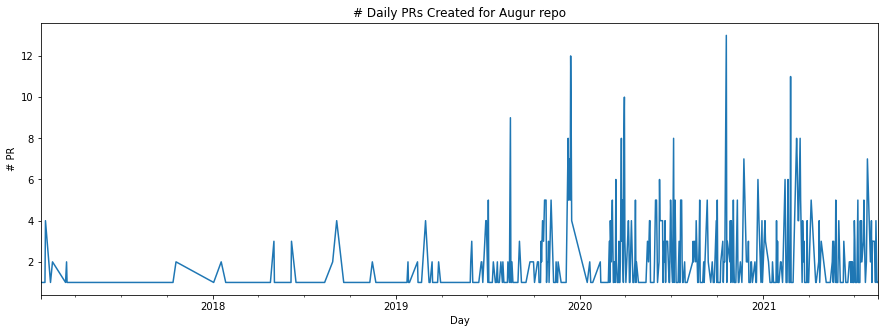

In [51]:
df_pr_daily.plot()

plt.xlabel("Year")
plt.ylabel("# PR")
plt.title("# Daily PRs Created for "+repo_focus.capitalize() +" repo")
plt.show()

### By week

In [52]:
df_pr_weekly = df_pr_focus['created'].groupby(df_pr_focus.created.dt.to_period("W")).agg('count')

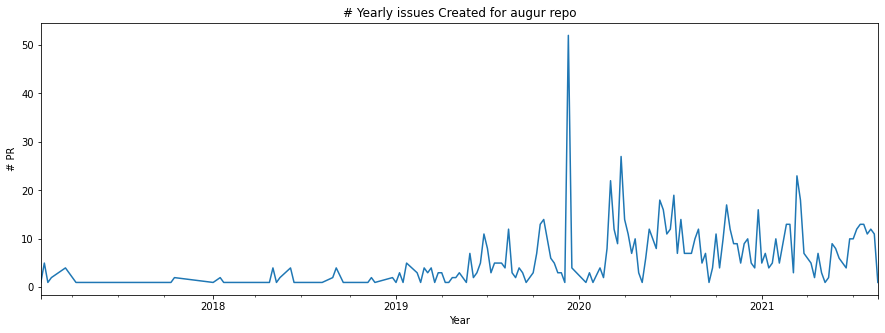

In [53]:
df_pr_weekly.plot()

plt.xlabel("Year")
plt.ylabel("# PR")
plt.title("# Weekly issues Created for "+repo_focus.capitalize() +" repo")
plt.show()

### By Month

In [41]:
df_pr_monthly = df_pr_focus['created'].groupby(df_pr_focus.created.dt.to_period("M")).agg('count')

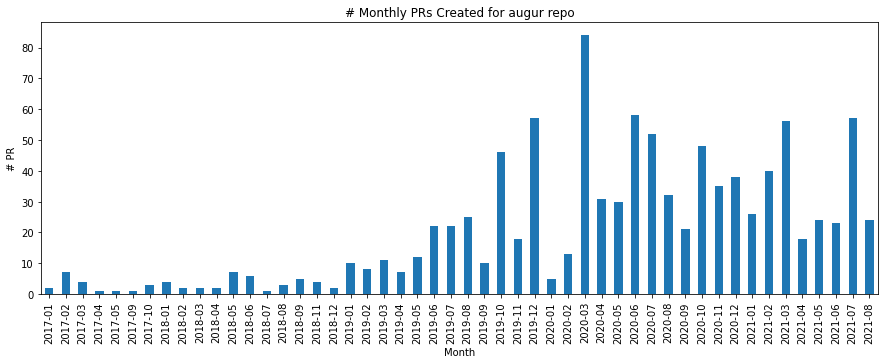

In [54]:
df_pr_monthly.plot.bar()

plt.xlabel("Month")
plt.ylabel("# PR")
plt.title("# Monthly PRs Created for "+repo_focus.capitalize() +" repo")
plt.show()

## Numer of PRs closed 

### By Day

In [45]:
df_pr_closed_daily = df_pr_focus['closed'].groupby(df_pr_focus.closed.dt.to_period("D")).agg('count')

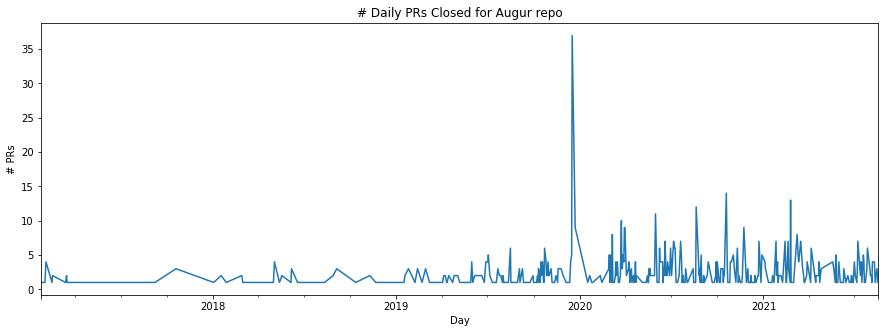

In [56]:
df_pr_closed_daily.plot()

plt.xlabel("Year")
plt.ylabel("# PRs")
plt.title("# Daily PRs Closed for "+repo_focus.capitalize() +" repo")
plt.show()

### By Week

In [57]:
df_pr_closed_weekly = df_pr_focus['closed'].groupby(df_pr_focus.closed.dt.to_period("W")).agg('count')

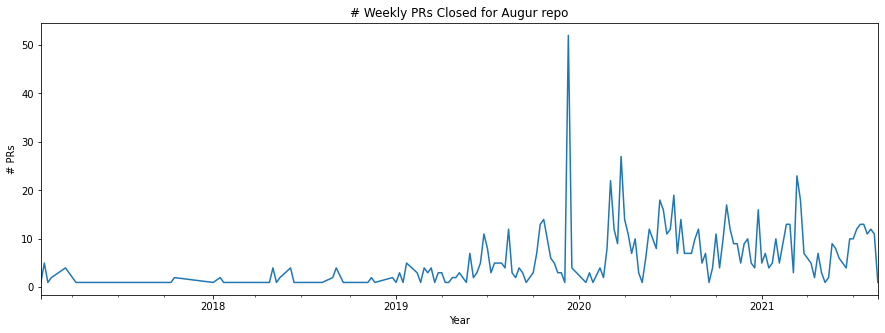

In [59]:
df_pr_weekly.plot()

plt.xlabel("Year")
plt.ylabel("# PRs")
plt.title("# Weekly PRs Closed for "+repo_focus.capitalize() +" repo")
plt.show()

### By Month

In [47]:
df_pr_closed_monthly = df_pr_focus['closed'].groupby(df_pr_focus.closed.dt.to_period("M")).agg('count')

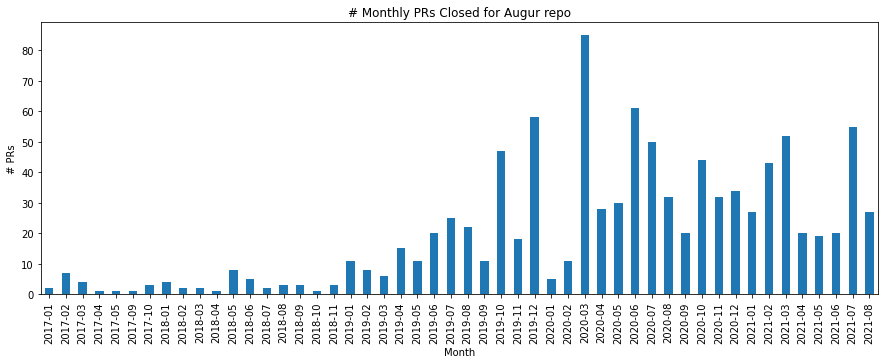

In [60]:
df_pr_closed_monthly.plot.bar()

plt.xlabel("Month")
plt.ylabel("# PRs")
plt.title("# Monthly PRs Closed for "+repo_focus.capitalize() +" repo")
plt.show()

## Numer of PRs open (by hour/day/week)

see above :) 

## Number of Reviews started/closed (by hour/day/week)

### Number of assignees

### Commits 